In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

#df['phase'] = df['phase'].replace({'M': 'G2'})

# Separate features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])  # exclude phase and age
y = df['age']  # target is now age

In [3]:
# Split data into train and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Train Random Forest Regressor with 500 trees and max depth 15
rf = RandomForestRegressor(n_estimators=500, max_depth=50, max_features='sqrt', random_state=949)

In [ ]:
## hypertuning

param_grid = {
    'n_estimators': [600, 700]              
    #'max_depth': [40, 50, 60]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring= 'neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 600}


In [7]:
# OOB error 
# Define the values of max_features to test
max_features_options = ['sqrt', 100, 150, 200, None]  # Try 3–5 reasonable values

oob_results = {}

# Loop over different max_features
for mf in max_features_options:
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=50,
        max_features=mf,
        oob_score=True,
        bootstrap=True,
        random_state=949,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    oob_results[mf] = root_mean_squared_error(y_train, rf.oob_prediction_)


# Show OOB results
print("=== OOB Scores by max_features ===")
for mf, score in oob_results.items():
    print(f"max_features={mf}: OOB Accuracy = {score:.4f}")

# Choose best setting
best_mf = max(oob_results, key=oob_results.get)
print(f"\nBest max_features based on OOB: {best_mf}")

=== OOB Scores by max_features ===
max_features=sqrt: OOB Accuracy = 1.6585
max_features=100: OOB Accuracy = 1.2706
max_features=150: OOB Accuracy = 1.2208
max_features=200: OOB Accuracy = 1.2220
max_features=None: OOB Accuracy = 1.2638

Best max_features based on OOB: sqrt


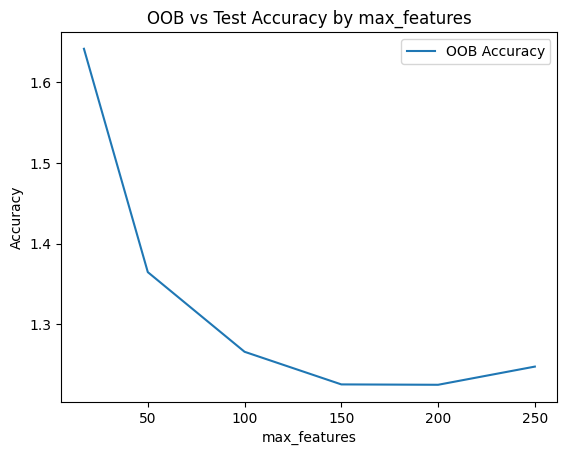

In [ ]:
## OOB plot
max_features_range = [17, 50, 100, 150, 200, 250]  # example for 300 features
oob_scores = []

for mf in max_features_range:
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=50,
        max_features=mf,
        oob_score=True,
        random_state=42,
        bootstrap=True
    )
    rf.fit(X_train, y_train)
    
    oob_scores.append(root_mean_squared_error(y_train, rf.oob_prediction_))

plt.plot(max_features_range, oob_scores, label="OOB Accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("OOB vs Test Accuracy by max_features")
plt.legend()
plt.show()

In [4]:
#retrain 
rf = RandomForestRegressor(n_estimators=600, max_depth=50, max_features=150, random_state=949)
rf.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [5]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 0.4515

=== Test Set ===
RMSE: 1.3132
RMSE per phase (Train):
phase
G0    0.475447
G1    0.364749
G2    0.443821
M     1.494292
S     0.488504
dtype: float64

RMSE per phase (Test):
phase
G0    1.451624
G1    1.038931
G2    1.408207
M     3.398515
S     1.393822
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_17484/3283991567.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_17484/3283991567.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


In [7]:
# === Load existing results DataFrame ===
results_df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv", index_col=0)

# === Set values ===
model_name = "RF (full)"  # or whatever is appropriate
results_df.loc[model_name, 'Overall'] = rmse_test

# Fill in per-phase RMSEs
for phase in ['G0', 'G1', 'G2', 'M', 'S']:
    if phase in rmse_per_phase_test.index:
        results_df.loc[model_name, phase] = rmse_per_phase_test[phase]

# === Save updated results ===
results_df.to_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv")

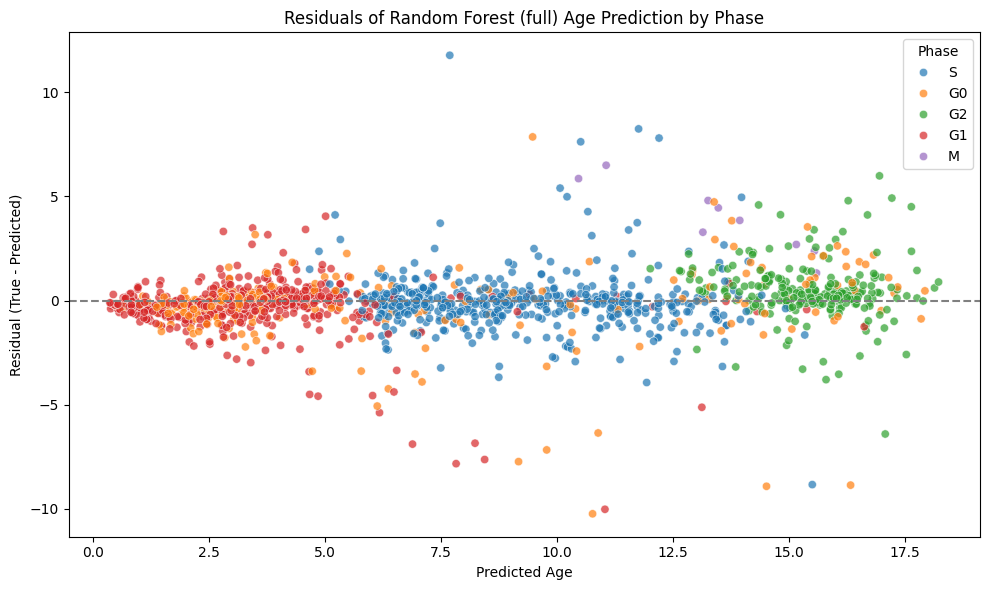

In [10]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': y_test_pred,
    'Residual': y_test - y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Random Forest (full) Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual (True - Predicted)")
plt.legend(title='Phase')
plt.tight_layout()

# Save the plot
plot_path = "rf_regression_full.png"
plt.savefig(plot_path, dpi=300)
plt.show()

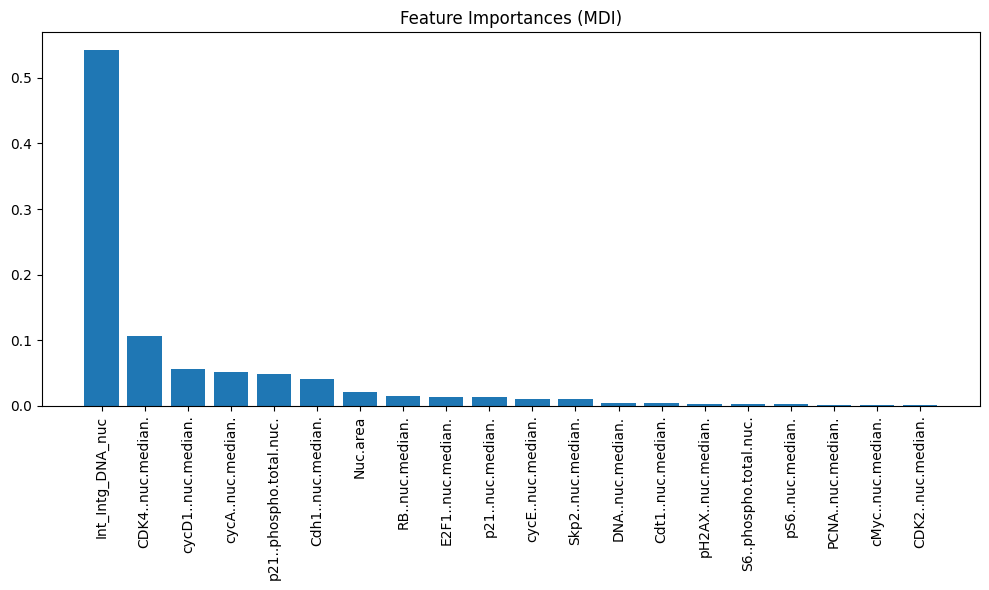

                     Feature  MDI Importance
4           Int_Intg_DNA_nuc        0.542447
26         CDK4..nuc.median.        0.105532
2         cycD1..nuc.median.        0.055842
1          cycA..nuc.median.        0.051681
241  p21..phospho.total.nuc.        0.048454
..                       ...             ...
135         pp21..PN.median.        0.000058
182         cJun..PN.median.        0.000056
74        cJun..cell.median.        0.000055
144        p27..cyto.median.        0.000052
130        pH2AX..PN.median.        0.000051

[262 rows x 2 columns]


In [18]:
# Get feature importances (MDI)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]  # Sort by importance descending

# Select top n indices
top_n = 20
top_indices = indices[:top_n]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (MDI)")
plt.bar(range(top_n), importances[top_indices], align='center')
plt.xticks(range(top_n), feature_names[top_indices], rotation=90)
plt.tight_layout()
plt.show()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'MDI Importance': importances
}).sort_values(by='MDI Importance', ascending=False)

print(importance_df)

<Axes: title={'center': 'Random Forest MDI (Top 20)'}>

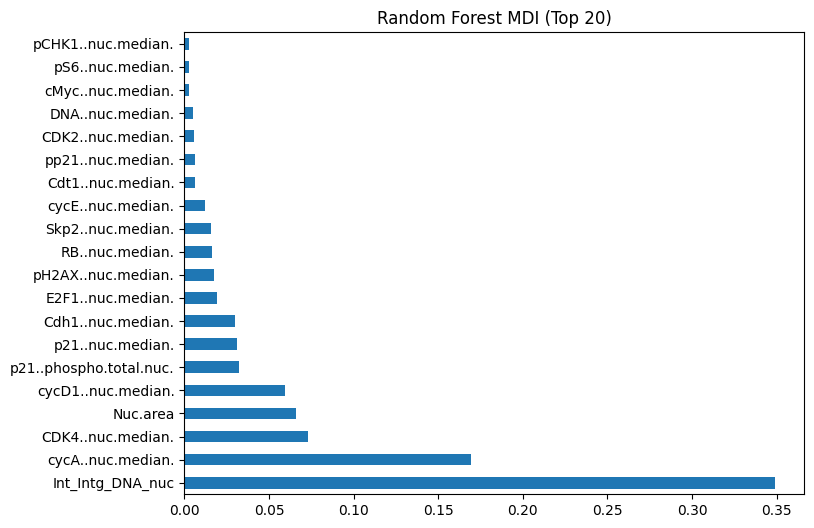

In [5]:
# Extract MDI importances
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
rf_importances_sorted = rf_importances.sort_values(ascending=False)

# Top features
rf_importances_sorted.head(20).plot(kind='barh', figsize=(8, 6), title='Random Forest MDI (Top 20)')